<a href="https://colab.research.google.com/github/mrdo19111911/3D-Loading-Divide-space-2.0/blob/main/class_Giant_Tour.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 thư viện

In [ ]:
!pip install ortools
!pip install kmedoids

import math
import numpy as np
import random as rd
import numba
from numba import njit
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import kmedoids
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

%matplotlib inline
from matplotlib.pyplot import figure
import graphviz

In [ ]:

from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

# 2 fake Data for input


In [ ]:
color_list =  ['k','g', 'r','b', 'dimgray', 'lime', 'orange', 'tomato', 'steelblue', 'hotpink', 'pink', 'y', 'navy']

n = 50
small_n= round(n/10) 
num_vehicles = 40
depot = 0
number_of_depots = 3
number_of_clusters = 20
max_travel = 200000000


## 2.1 location và distance matrix

In [ ]:
@njit
def create_location(n, small_n):

    location = np.empty((n,2), np.int_)
    for i in range(small_n):
        location[i][0],location[i][1]= rd.randint(0,1000), rd.randint(0,1000)
    for i in range(3*small_n): 
        location[i+small_n][0],location[i+small_n][1]= rd.randint(0,1000), rd.randint(0,1000)
        location[i+small_n*4][0],location[i+small_n*4][1]= rd.randint(0,1000), rd.randint(0,1000)
        location[i+small_n*7][0],location[i+small_n*7][1]= rd.randint(0,1000), rd.randint(0,1000)

    return location


def create_distance_matrix(location, n):

    @njit
    def create_DM(location, n): 
        DM = np.empty((n,n), np.int_)

        for i in range(n):
            for j in range(n):
                DM[i,j] =round(math.sqrt( (location[i][0]-location[j][0])**2+ (location[i][1]-location[j][1])**2 ))

        return DM
    
    return create_DM(location, n)



# khởi tạo location và distance matrix


location = create_location(n, small_n)
DM = create_distance_matrix(location, n)  

len(DM)

50

Chi phí của một xe trên một trip gồm:

1-Chi phí cố định, chỉ cần mở cửa xe là mất. Ví dụ 12000 với tacxi.

2-Chi phí thay đổi, phụ thuộc vào quãng đường di chuyển. Gồm giá tiền/ km nhân với quãng đường di chuyển. 

full price = deply cost+ distance*ppk

## 2.2 class Vehicle and fake

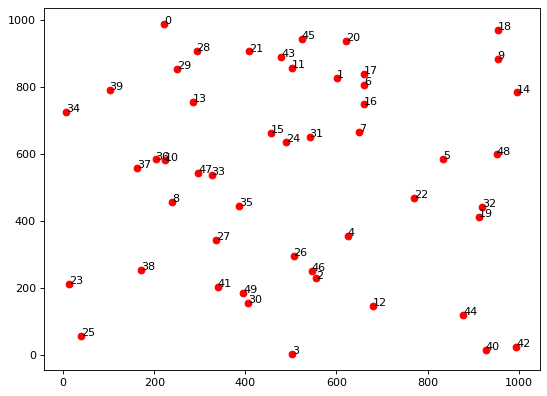

In [ ]:


plt.figure(figsize=(8, 6), dpi=80)

# plt.rcParams["figure.figsize"] = (20,30)
X= [location[i][0] for i in range(len(location))]
Y= [location[i][1] for i in range(len(location))]
plt.plot(X,Y,'ro')
for i in range(len(X)):
    plt.text(X[i],Y[i],str(i))


3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


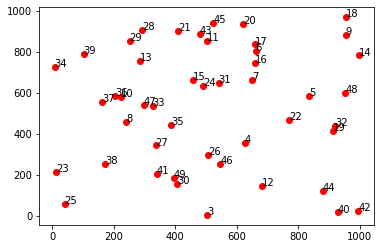

In [ ]:
class Vehicle:
    def __init__(self, capacity, cbm, deploy_cost, ppk, id): 
        self.capacity = capacity
        self.cbm = cbm
        self.deploy_cost =  deploy_cost   # deploy_cost: chi phí cố định để xe chạy ví dụ lương tài xế
        self.ppk = ppk        #  ppk là chi phí giá đi trên một km. 
        self.vehicle_code = id

# FAKE thêm tập xe 
def create_vehical_array(num_vehicle): # số xe trong kho phải biết trước
    vehicle_list=[]
    for i in range(num_vehicle):
        x=rd.randint(1000,10000)
        vehicle_list.append(  Vehicle( x, x, x*10, x, i))
    
    return vehicle_list

@njit

def create_request(n, number_of_depots):

    req_list = np.empty((n-number_of_depots,2), np.int_) 
    for i in range(n-number_of_depots): 
        req_list[i][0] =  0
        if i > n*0.8:
            req_list[i][0] = i%number_of_depots

        # rd.randint(0, number_of_depots-1)
        req_list[i][1] =  i+number_of_depots

    return req_list

req_list = create_request(n, number_of_depots)


n_req =n-number_of_depots
def create_distance_matrix_for_request( req_list, DM):
    # req_lisst khác với location, vì không bao gồm depot. 
    # req_list[i][0] = depot
    # req_list[i][1] : điểm giao
    n= len(req_list)
    DM_req = np.empty((n,n), np.int_)
    for i in range(n):
        for j in range(n): 
            DM_req[i,j] = DM[req_list[i][0]][req_list[j][0]] + DM[req_list[i][1]][req_list[j][1]] 
    
    return DM_req
DM_req = create_distance_matrix_for_request( req_list, DM)
len(DM_req)
for i in range(len(req_list)):
    print(req_list[i][1])
    plt.plot(*location[req_list[i][1]], "ro")
    plt.text(*location[req_list[i][1]], str(req_list[i][1]))

# 3 tạo giant tour

In [ ]:
@njit
def LS( giant_tour,DM_req, iteration_num=0):
    # DM_req =  self.DM_req
    print(giant_tour[1])
    for k in range(10):
        for i in range(1,len(giant_tour)-2):
            if DM_req[giant_tour[i-1]][giant_tour[i]]+ DM_req[giant_tour[i+2]][giant_tour[i+1]]>  DM_req[giant_tour[i-1]][giant_tour[i+1]]+ DM_req[giant_tour[i]][giant_tour[i+2]]:
                x= giant_tour[i+1]
                giant_tour[i+1]=giant_tour[i]
                giant_tour[i] =x
    return giant_tour

cluster_result [[43, 46], [6, 11, 15], [0, 9, 20, 22, 23, 24, 27, 35, 38], [5, 7, 10, 30, 31, 32, 33, 34, 36], [8, 14, 17, 18, 25, 26, 40, 42], [3, 4, 12, 13, 21, 28], [1, 2, 16, 19, 29, 37, 39, 45], [41, 44]]
center_point [43  6 38  7 40 28 16 41]
[[0 1]
 [6 5]
 [5 3]
 [2 0]
 [1 2]
 [2 1]
 [7 5]
 [0 1]]
46 49
30 27
35 33
15 6
17 20
18 14
48 40
44 47
46
GT_between_cluster [0, 2, 3, 5, 4, 1, 6, 7]
[43 46 27 38 35 20 22  0  9 23 24 32  5  7 33 34 31 36 10 30 12 21 28  4
 13  3 14  8 26 25 18 40 42 17 15  6 11 45  2 29 16 19  1 37 39 41 44]


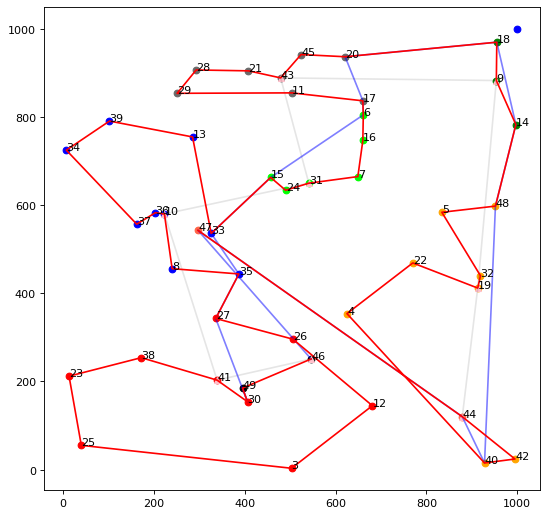

In [ ]:
class GT:
    def __init__(self, DM_req, size_of_clusters):
        self.DM_req = DM_req
        self.size_of_clusters = size_of_clusters

    def total_clustering(self, DM_req, size_of_clusters):
    # DM_req, number_of_clusters, small_cluster_num
        DM_req= self.DM_req
        size_of_clusters=self.size_of_clusters
        def fasterpam(small_list_req, DM_req, number_cluster):
            n_DM_req= len(small_list_req)
            cut_DM_req = np.empty((n_DM_req,n_DM_req), np.int_)
            for i in range(n_DM_req): 
                for j in range(n_DM_req): 
                    cut_DM_req[i,j] = DM_req[small_list_req[i],small_list_req[j]]

            c = kmedoids.fasterpam(cut_DM_req, number_cluster)
            d = c.labels.astype(np.int_) 

            mylist=[ [i, d[i]] for i in range(len(small_list_req))]

            values = set(map(lambda x:x[1], mylist))
            list_of_point_in_same_cluster = [[small_list_req[y[0]] for y in mylist if y[1]==x]\
                                            for x in values ]

            return list_of_point_in_same_cluster, d
        # batch_cluster =
        final_cluster =[]
        number_cluster = math.floor(len(DM_req)/ size_of_clusters )+1
        batch_cluster, _ = fasterpam(list(range(len(DM_req))), DM_req,  number_cluster)
        # (small_list_req, DM_req, number_cluster):
        i=0
        while True:

            if len(batch_cluster[i])> size_of_clusters*3: 
                sub_number_cluster=math.ceil(len(batch_cluster[i])/ size_of_clusters)  
                new_cluster, _ = fasterpam(batch_cluster[i], DM_req,  sub_number_cluster)
                batch_cluster.pop(i)
                batch_cluster =  batch_cluster + new_cluster  
                i=i-1
            else:
                final_cluster.append(batch_cluster[i]) 
                batch_cluster.pop(i)  
                i=i-1
                
            i=i+1
            if len(batch_cluster) ==0:
                break
            if i> len(batch_cluster):
                break

        return final_cluster

    def create_center_point(self, cluster_result, DM_req):

        center_point= np.empty((len(cluster_result) ), np.int_) 
        i=0
        for cluster in cluster_result:
            A= [[point, sum([DM_req[point][i] for i in cluster    ] )  ]   for point in cluster] 
            x=min(A, key= lambda x:x[1])
            center_point[i]=x[0] 
            i=i+1

        return center_point

    def create_distance_matrix_center_point(self, center_point, DM_req):

        DM_center = np.empty((len(center_point),len(center_point)), np.int_) 
        for i in range(len(center_point)):
            for j in range(len(center_point)):
                DM_center[i][j] = DM_req[center_point[i]][center_point[j]] 

        return DM_center
    def create_data_model_for_center_points(self, DM_center, list_point, depot_index):
        data = {}

        data['distance_matrix'] = DM_center
        # create_dm(list_point,DM) 
        data['num_vehicles'] = 1
        
        # if is_start_end==False:
        data['depot'] = depot_index

        return data




    def create_route_of_cluster(self, data):
            
        def print_solution_center(manager, routing, solution):

            """Prints solution on console."""

            print('Objective: {} miles'.format(solution.ObjectiveValue()))
            index = routing.Start(0)
            plan_output = 'Route for vehicle 0:\n'
            route_distance = 0

            while not routing.IsEnd(index):
                plan_output += ' {} ->'.format(manager.IndexToNode(index))
                previous_index = index
                index = solution.Value(routing.NextVar(index))
                route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)

            plan_output += ' {}\n'.format(manager.IndexToNode(index))
            print(plan_output)
            plan_output += 'Route distance: {}miles\n'.format(route_distance)
        # chuyển solution sang dạng mảng
        def get_routes(solution, routing, manager):
            routes = []

            for route_nbr in range(routing.vehicles()):
                index = routing.Start(route_nbr)
                route = [manager.IndexToNode(index)]

                while not routing.IsEnd(index):
                    index = solution.Value(routing.NextVar(index))
                    route.append(manager.IndexToNode(index))
                routes.append(route)

            return routes
        # if data['is_start_end'] == False:
        manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']), data['num_vehicles'], data['depot']) 
        # else:
        #     manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']), data['num_vehicles'], data['starts'], data['ends'])

        routing = pywrapcp.RoutingModel(manager) 

        def distance_callback(from_index, to_index):
            from_node = manager.IndexToNode(from_index) 
            to_node = manager.IndexToNode(to_index) 
            return data['distance_matrix'][from_node][to_node] 

        transit_callback_index = routing.RegisterTransitCallback(distance_callback)
        routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

        dimension_name = 'Distance'
        routing.AddDimension(
            transit_callback_index,
            0,  
            3000000,  
            True,  
            dimension_name)
        distance_dimension = routing.GetDimensionOrDie(dimension_name)
        # distance_dimension.SetGlobalSpanCostCoefficient(100)

        search_parameters = pywrapcp.DefaultRoutingSearchParameters()
        search_parameters.first_solution_strategy = (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
        # search_parameters.local_search_metaheuristic = (routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
        # search_parameters.time_limit.seconds  = 1
        # search_parameters.solution_limit = 1
        # search_parameters.log_search = True

        solution = routing.SolveWithParameters(search_parameters)

        if solution:
            # print_solution(manager, routing, solution)
            routes = get_routes(solution, routing, manager)
            return routes 
        else:
            return 'false solution'

    def create_in_out(self, GT_cluster_list, DM_req):
        in_out = np.empty( (len(GT_cluster_list), 2), np.int_)
        for i in range(len(in_out)):
            in_out[i][0], in_out[i][1]=-1,-1
        for this_i in range(len( GT_cluster_list)):
            next_i= (this_i+1)%len(GT_cluster_list)
            # print(this_i, next_i)
            A = [i for i in range(len(GT_cluster_list[this_i]))  if i!=in_out[this_i][0]]
            B=[j for j in range(len(GT_cluster_list[next_i] )) if j!=in_out[next_i][1] ]
            if len(A)==0:
                A= [i for i in range(len(GT_cluster_list[this_i])) ]
            if len(B)==0:
                B=[j for j in range(len(GT_cluster_list[next_i]))  ]
            # print("A,B, index: ",A,B)
            pair_1 = [[i, j] for i in A for j in B  ]
            # print("GT, original " , GT_cluster_list[this_i], GT_cluster_list[next_i])
            # print("pair_1", pair_1)
            pair = [[i, j,DM_req[GT_cluster_list[this_i][i]]  [GT_cluster_list[next_i][j]]] for i in A for j in B  ]
            pair.sort(key=lambda x: x[2])

            # pair = [[i, j, DM_req[GT_cluster_list[this_i][i]]  [GT_cluster_list[next_i][j]]] for i in A for j in B  ]

            # print(pair)
            in_out[this_i][1]=pair[0][0]
            in_out[next_i][0]=pair[0][1]

            # print("___________")

        return in_out
    def find_route_inside_cluster(self, GT_cluster_list, DM_req, this_i, in_out):


        size_cluster =  len(GT_cluster_list[this_i])
        data = {}
        
        data['distance_matrix'] = DM_req
        # create_dm(list_point,DM) 
        data['num_vehicles'] = 1
        
        # if is_start_end==False:
        data['starts'] = [int(in_out[this_i][0])]
        data['ends'] = [int(in_out[this_i][1])]
        
        # else:
        # size_cluster, 1, in_out[this_i][0], in_out[this_i][1]
        # manager = pywrapcp.RoutingIndexManager(data)
        # print(len(GT_cluster_list[this_i]), data['starts'] , data['ends'])
        manager = pywrapcp.RoutingIndexManager(size_cluster, 1, data['starts'] , data['ends'] )
        manager = pywrapcp.RoutingIndexManager(len(GT_cluster_list[this_i]), 1, data['starts'], data['ends'])
    # routing = pywrapcp.RoutingModel(manager)
        def distance_callback(from_index, to_index):
            from_node = manager.IndexToNode(from_index) 
            to_node = manager.IndexToNode(to_index) 
            return DM_req[GT_cluster_list[this_i] [from_node]]   [GT_cluster_list[this_i][to_node]] 
        routing = pywrapcp.RoutingModel(manager) 

        transit_callback_index = routing.RegisterTransitCallback(distance_callback)
        routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

        dimension_name = 'Distance'
        routing.AddDimension(
            transit_callback_index,
            0,  
            3000000,  
            True,  
            dimension_name)
        distance_dimension = routing.GetDimensionOrDie(dimension_name)
        # distance_dimension.SetGlobalSpanCostCoefficient(100)

        search_parameters = pywrapcp.DefaultRoutingSearchParameters()
        search_parameters.first_solution_strategy = (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
        # search_parameters.local_search_metaheuristic = (routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
        # search_parameters.time_limit.seconds  = 1
        # search_parameters.solution_limit = 1
        # search_parameters.log_search = True

        def print_solution_sub(manager, routing, solution):
            
            """Prints solution on console."""

            # print('Objective: {} miles'.format(solution.ObjectiveValue()))
            index = routing.Start(0)
            # plan_output = 'Route for vehicle 0:\n'
            route_distance = 0
            trip=[]
            while not routing.IsEnd(index):
                # plan_output += ' {} ->'.format(manager.IndexToNode(index))
                trip.append(manager.IndexToNode(index))
                previous_index = index
                index = solution.Value(routing.NextVar(index))
                route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
            trip.append(manager.IndexToNode(index))

            # plan_output += ' {}\n'.format(manager.IndexToNode(index))
            # print(plan_output)
            # plan_output += 'Route distance: {}miles\n'.format(route_distance)
            return trip
        solution = routing.SolveWithParameters(search_parameters)

        if solution:
            routes= print_solution_sub(manager, routing, solution)
            # routes = get_routes(solution, routing, manager)
            B=[ GT_cluster_list[this_i][i] for i in routes]
            return B 
        else:
            return []
    def find_giant_tour(self, GT_cluster_list, DM_req, in_out):
        all_trip=[]
        for i in range(len(GT_cluster_list)):
            all_trip.append(self.find_route_inside_cluster(GT_cluster_list, DM_req,i, in_out))
        giant_tour = []
        for trip in all_trip:
            if trip[0]!=trip[-1]:
                giant_tour+=trip
            else: 
                giant_tour.append(trip[0])
        return giant_tour
    def draw_cluster_result(self,cluster_result, center_point=[], GT_between_cluster=[], in_out_original=[], giant_tour=[]):
        
        from matplotlib.pyplot import figure
        figure(figsize=(8, 8), dpi=80)        
        plt.plot(1000, 1000,"bo")

        for i in range(len(cluster_result)):
            for point in cluster_result[i]:
                p = point + number_of_depots
                print
                plt.plot( location[p][0], location[p][1],  color_list[i%len(color_list)], marker= "o", alpha=1 )
                plt.text( location[p][0], location[p][1], str(p))

        for point in center_point:
            
            p = point + number_of_depots
            plt.plot( location[p][0], location[p][1],  color = "pink", marker ="^")

        print("GT_between_cluster", GT_between_cluster)
        X=[]
        Y=[]
        for item in GT_between_cluster:
            p=center_point[item]+number_of_depots
            X.append(location[p][0])
            Y.append(location[p][1])
        plt.plot(X,Y,'k', alpha=0.1)

        X=[]
        Y=[]
        for i in range(len(in_out_original)):
            p=in_out_original[i][1]+number_of_depots
            X.append(location[p][0])
            Y.append(location[p][1])
            p=in_out_original[(i+1)%len(in_out_original)][0]+number_of_depots
            X.append(location[p][0])
            Y.append(location[p][1])
        plt.plot(X,Y,'b', alpha=0.5)
        print(giant_tour)
        X=[]
        Y=[]
        for i in range(len(giant_tour)):
            p=giant_tour[i]+number_of_depots
            X.append(location[p][0])
            Y.append(location[p][1])
        plt.plot(X,Y,'r', alpha=1)

    def create_draw_giant_tour(self):
        DM_req= self.DM_req
        size_of_clusters= self.size_of_clusters
        cluster_result = self.total_clustering( DM_req, size_of_clusters )
        print("cluster_result", cluster_result)

        center_point = self.create_center_point(cluster_result, DM_req)
        print("center_point", center_point)

        DM_center = self.create_distance_matrix_center_point(center_point, DM_req)
        DM_center
        GT_between_cluster=self.create_route_of_cluster(self.create_data_model_for_center_points(DM_center, center_point,0 ) )[0]
        GT_between_cluster= GT_between_cluster[:-1]

        GT_cluster_list=[cluster_result[i] for i in GT_between_cluster]


        plt.show()
        in_out= self.create_in_out(GT_cluster_list, DM_req)
        in_out_original = np.empty( (len(GT_between_cluster), 2), np.int_)
        print(in_out)
        for i in range(len(in_out)):
            in_out_original[i][0]= GT_cluster_list[i][in_out[i][0]]
            in_out_original[i][1]= GT_cluster_list[i][in_out[i][1]]
        for item in in_out_original:
            print(item[0]+number_of_depots, item[1]+number_of_depots)


# r(self, GT_cluster_list, DM_req, in_out)
        giant_tour = self.find_giant_tour(GT_cluster_list, DM_req, in_out)


        giant_tour= LS(np.array(giant_tour, np.int_),DM_req,5)
        self.draw_cluster_result(cluster_result,center_point,GT_between_cluster, in_out_original, giant_tour )

        self.giant_tour = np.array(giant_tour, np.int_)
        return giant_tour


    def create_giant_tour(self):
        DM_req= self.DM_req
        size_of_clusters= self.size_of_clusters
        cluster_result = self.total_clustering( DM_req, size_of_clusters )

        center_point = self.create_center_point(cluster_result, DM_req)

        DM_center = self.create_distance_matrix_center_point(center_point, DM_req)
        DM_center
        GT_between_cluster=self.create_route_of_cluster(self.create_data_model_for_center_points(DM_center, center_point,0 ) )[0]
        GT_between_cluster= GT_between_cluster[:-1]

        GT_cluster_list=[cluster_result[i] for i in GT_between_cluster]


        plt.show()
        in_out= self.create_in_out(GT_cluster_list, DM_req)
        in_out_original = np.empty( (len(GT_between_cluster), 2), np.int_)
        for i in range(len(in_out)):
            in_out_original[i][0]= GT_cluster_list[i][in_out[i][0]]
            in_out_original[i][1]= GT_cluster_list[i][in_out[i][1]]


        # plt.figure(figsize=(8, 6), dpi=80)

        # plt.plot(X,Y,'ro')
        # for i in range(len(X)):
        #     plt.text(X[i],Y[i],str(i))


        giant_tour = self.find_giant_tour(GT_cluster_list, DM_req, in_out)
        giant_tour= LS(np.array(giant_tour, np.int_),DM_req,0)
        self.giant_tour = np.array(giant_tour, np.int_)
        return giant_tour

    def help(self):
        text = " this program computes a giant tour formed by a Distant Matrix, and a number of approximate cluster size."
        text+="giant_tour_problem = GT(distant matrix, size of cluster). Output is a giant tour, in form of a list"
        text+="giant_tour_problem = gt.GT(DM_req,size_of_clusters= 6), s = giant_tour_problem.create_giant_tour()"
        print(text)
giant_tour_problem = GT(DM_req,6)
s = giant_tour_problem.create_draw_giant_tour()
# s = giant_tour_problem.create_giant_tour()


In [ ]:
req_list

array([[ 0,  3],
       [ 0,  4],
       [ 0,  5],
       [ 0,  6],
       [ 0,  7],
       [ 0,  8],
       [ 0,  9],
       [ 0, 10],
       [ 0, 11],
       [ 0, 12],
       [ 0, 13],
       [ 0, 14],
       [ 0, 15],
       [ 0, 16],
       [ 0, 17],
       [ 0, 18],
       [ 0, 19],
       [ 0, 20],
       [ 0, 21],
       [ 0, 22],
       [ 0, 23],
       [ 0, 24],
       [ 0, 25],
       [ 0, 26],
       [ 0, 27],
       [ 0, 28],
       [ 0, 29],
       [ 0, 30],
       [ 0, 31],
       [ 0, 32],
       [ 0, 33],
       [ 0, 34],
       [ 0, 35],
       [ 0, 36],
       [ 0, 37],
       [ 0, 38],
       [ 0, 39],
       [ 0, 40],
       [ 0, 41],
       [ 0, 42],
       [ 0, 43],
       [ 2, 44],
       [ 0, 45],
       [ 1, 46],
       [ 2, 47],
       [ 0, 48],
       [ 1, 49]])

#end GT

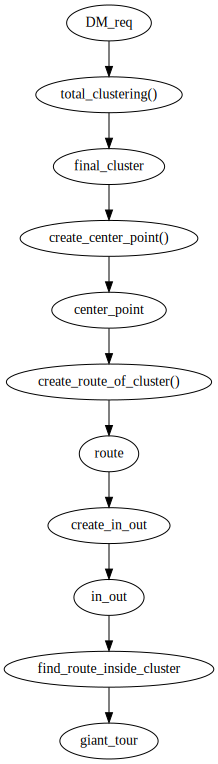

In [ ]:

dot = graphviz.Digraph(comment='The Round Table')



dot.node('A', "DM_req")  # doctest: +NO_EXE
dot.node('B', 'total_clustering()')
dot.node('C', 'final_cluster')

dot.node('D', 'create_center_point()')
dot.node('E', "center_point")
dot.node('F', "create_route_of_cluster()")

dot.node('G', "route")
dot.node('H', "create_in_out")
dot.node('I', "in_out")
dot.node('K', "find_route_inside_cluster")
dot.node('L', "giant_tour")
dot.node('I', "in_out")
dot.node('I', "in_out")
dot.node('I', "in_out")
dot.node('I', "in_out")

dot.edges(['AB', 'BC',"CD", "DE","EF", "FG", "GH", "HI", "IK", "KL"])
dot

# 4 visualization solve

Vẽ ra hình: 

Result: 

# 5 bài toán thêm tập điểm tập xe

In [ ]:
input =[]
list_point = []
for i in range(len(s)):
    input.append(req_list[s[i]])
    if req_list[s[i]][0] not in list_point:
        list_point.append(req_list[s[i]][0])
    if req_list[s[i]][1] not in list_point:
        list_point.append(req_list[s[i]][1])
solve_PD_VRP(input, list_point)

Objective: 226116
Route for vehicle 0:
 0 ->  13 ->  15 ->  11 ->  12 -> 0
Distance of the route: 1552m

Route for vehicle 1:
 0 ->  5 ->  2 ->  10 ->  16 ->  14 ->  9 -> 0
Distance of the route: 2192m

Route for vehicle 2:
 0 ->  4 ->  3 -> 0
Distance of the route: 1392m

Route for vehicle 3:
 0 ->  7 ->  1 ->  6 ->  8 -> 0
Distance of the route: 1780m

Total Distance of all routes: 6916m
Objective: 226116
Route for vehicle 0:
 0 ->  13 ->  15 ->  11 ->  12 -> 0
Distance of the route: 1552m

Route for vehicle 1:
 0 ->  5 ->  2 ->  10 ->  16 ->  14 ->  9 -> 0
Distance of the route: 2192m

Route for vehicle 2:
 0 ->  4 ->  3 -> 0
Distance of the route: 1392m

Route for vehicle 3:
 0 ->  7 ->  1 ->  6 ->  8 -> 0
Distance of the route: 1780m

Total Distance of all routes: 6916m
Objective: 226116
Route for vehicle 0:
 0 ->  13 ->  15 ->  11 ->  12 -> 0
Distance of the route: 1552m

Route for vehicle 1:
 0 ->  5 ->  2 ->  10 ->  16 ->  14 ->  9 -> 0
Distance of the route: 2192m

Route for v

In [ ]:




def create_data_model_solve_PD_VRP(input, list_point):
    """Stores the data for the problem."""
    
    list_point = []
    for req in input:
        if req[0] not in list_point:
            list_point.append(req[0])
        if req[1] not in list_point:
            list_point.append(req[1])
    print(list_point)

    data = {}
    data['distance_matrix'] = [
        [
            0, 548, 776, 696, 582, 274, 502, 194, 308, 194, 536, 502, 388, 354,
            468, 776, 662
        ],
        [
            548, 0, 684, 308, 194, 502, 730, 354, 696, 742, 1084, 594, 480, 674,
            1016, 868, 1210
        ],
        [
            776, 684, 0, 992, 878, 502, 274, 810, 468, 742, 400, 1278, 1164,
            1130, 788, 1552, 754
        ],
        [
            696, 308, 992, 0, 114, 650, 878, 502, 844, 890, 1232, 514, 628, 822,
            1164, 560, 1358
        ],
        [
            582, 194, 878, 114, 0, 536, 764, 388, 730, 776, 1118, 400, 514, 708,
            1050, 674, 1244
        ],
        [
            274, 502, 502, 650, 536, 0, 228, 308, 194, 240, 582, 776, 662, 628,
            514, 1050, 708
        ],
        [
            502, 730, 274, 878, 764, 228, 0, 536, 194, 468, 354, 1004, 890, 856,
            514, 1278, 480
        ],
        [
            194, 354, 810, 502, 388, 308, 536, 0, 342, 388, 730, 468, 354, 320,
            662, 742, 856
        ],
        [
            308, 696, 468, 844, 730, 194, 194, 342, 0, 274, 388, 810, 696, 662,
            320, 1084, 514
        ],
        [
            194, 742, 742, 890, 776, 240, 468, 388, 274, 0, 342, 536, 422, 388,
            274, 810, 468
        ],
        [
            536, 1084, 400, 1232, 1118, 582, 354, 730, 388, 342, 0, 878, 764,
            730, 388, 1152, 354
        ],
        [
            502, 594, 1278, 514, 400, 776, 1004, 468, 810, 536, 878, 0, 114,
            308, 650, 274, 844
        ],
        [
            388, 480, 1164, 628, 514, 662, 890, 354, 696, 422, 764, 114, 0, 194,
            536, 388, 730
        ],
        [
            354, 674, 1130, 822, 708, 628, 856, 320, 662, 388, 730, 308, 194, 0,
            342, 422, 536
        ],
        [
            468, 1016, 788, 1164, 1050, 514, 514, 662, 320, 274, 388, 650, 536,
            342, 0, 764, 194
        ],
        [
            776, 868, 1552, 560, 674, 1050, 1278, 742, 1084, 810, 1152, 274,
            388, 422, 764, 0, 798
        ],
        [
            662, 1210, 754, 1358, 1244, 708, 480, 856, 514, 468, 354, 844, 730,
            536, 194, 798, 0
        ],
    ]
    data['pickups_deliveries'] = [
        [1, 6],
        [2, 10],
        [4, 3],
        [5, 9],
        [7, 8],
        [15, 11],
        [13, 12],
        [16, 14],
    ]
    data['num_vehicles'] = 4
    data['depot'] = 0
    return data


def print_solution_PD_VRP(data, manager, routing, solution):
    """Prints solution on console."""
    print(f'Objective: {solution.ObjectiveValue()}')
    total_distance = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output += ' {} -> '.format(manager.IndexToNode(index))
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += '{}\n'.format(manager.IndexToNode(index))
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        print(plan_output)
        total_distance += route_distance
    print('Total Distance of all routes: {}m'.format(total_distance))


def solve_PD_VRP(input, list_point):
    """Entry point of the program."""
    # Instantiate the data problem.
    data = create_data_model_solve_PD_VRP(input, list_point)

    # Create the routing index manager.
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                           data['num_vehicles'], data['depot'])

    # Create Routing Model.
    routing = pywrapcp.RoutingModel(manager)


    # Define cost of each arc.
    def distance_callback(from_index, to_index):
        """Returns the manhattan distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Add Distance constraint.
    dimension_name = 'Distance'
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        3000,  # vehicle maximum travel distance
        True,  # start cumul to zero
        dimension_name)
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)

    # Define Transportation Requests.
    for request in data['pickups_deliveries']:
        pickup_index = manager.NodeToIndex(request[0])
        delivery_index = manager.NodeToIndex(request[1])
        routing.AddPickupAndDelivery(pickup_index, delivery_index)
        routing.solver().Add(
            routing.VehicleVar(pickup_index) == routing.VehicleVar(
                delivery_index))
        routing.solver().Add(
            distance_dimension.CumulVar(pickup_index) <=
            distance_dimension.CumulVar(delivery_index))

    # Setting first solution heuristic.
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PARALLEL_CHEAPEST_INSERTION)

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    # Print solution on console.
    if solution:
        print_solution_PD_VRP(data, manager, routing, solution)


if __name__ == '__main__':
    solve_PD_VRP(input, list_point)

[1, 46, 49, 0, 30, 41, 38, 23, 25, 3, 12, 26, 27, 35, 8, 10, 36, 37, 34, 39, 13, 33, 15, 24, 31, 7, 16, 6, 17, 11, 29, 28, 21, 43, 45, 20, 18, 9, 14, 48, 5, 32, 19, 22, 4, 40, 42, 2, 44, 47]
Objective: 226116
Route for vehicle 0:
 0 ->  13 ->  15 ->  11 ->  12 -> 0
Distance of the route: 1552m

Route for vehicle 1:
 0 ->  5 ->  2 ->  10 ->  16 ->  14 ->  9 -> 0
Distance of the route: 2192m

Route for vehicle 2:
 0 ->  4 ->  3 -> 0
Distance of the route: 1392m

Route for vehicle 3:
 0 ->  7 ->  1 ->  6 ->  8 -> 0
Distance of the route: 1780m

Total Distance of all routes: 6916m


## data model

## 5.3 create data for subproblems.

In [ ]:

# thêm tập điểm 
def create_point_array(start, step, point_input):
    fetch_input = []  
    len_p = len(point_input)
    for x in range(1, len_p, step):
        fetch_input.append(point_input[x:x+step]) 

    return fetch_input




# fake time mt
def create_time_matrix(limited_point):
    tw = np.empty( (limited_point, limited_point), np.int_)
    for i in range(limited_point):
        for j in range(limited_point):
            tw[i][j] = round(DM[i][j] / 10000 )

    return tw


# fake tw
def create_time_window(limited_point):
    tw = np.empty( (limited_point, 2), np.int_)
    for i in range(limited_point):
        tw[i] = (rd.randint(4,11) , rd.randint(13000,22000))
    return tw

In [ ]:
def create_data_model(DM, initial_routes, num_vehicles, depot, time_matrix, time_windows):
    result = {}

    result['distance_matrix'] = DM
    result['initial_routes'] = initial_routes
    result['num_vehicles'] = num_vehicles
    result['depot'] = depot
    result['time_matrix'] = time_matrix
    result['time_windows'] = time_windows
    
    if len(time_matrix) !=len(time_windows):
        print("loi tw, tm", len(time_matrix), len(time_windows))
    if len(DM) !=len(time_windows):
        print("loi tw, tm", len(DM), len(time_windows))
    if len(DM) !=len(time_matrix):
        print("loi tw, tm", len(DM), len(time_matrix))

    return result

## cut matrix contraints

In [ ]:
def cut_distance_matrixs( distance_matrix_ar, add_array):

    len_add_array = len(add_array)
    distance_matrix = np.empty((len_add_array,len_add_array),dtype=np.int_)
    for i in range(len_add_array):
        for j in range(len_add_array):
            distance_matrix[i][j] = DM[add_array[i]][add_array[j]]

    return distance_matrix


def cut_timewindow_constraint( tw, add_array):
    k = len(add_array)
    res = np.empty((k,len(tw[0])),dtype=np.int_)
    for i in range(k):
        res[i]= tw[add_array[i]]

    return res


def cut_time_matrixs( time_matrix_ar, add_array):
    len_add_array = len(add_array)
    time_matrix = np.empty((len_add_array,len_add_array), dtype=np.int_)
    for i in range(len_add_array):
        for j in range(len_add_array):
            time_matrix[i][j] = DM[add_array[i]][add_array[j]]

    return time_matrix

## solve

In [ ]:
def solve_vrp(data, max_travel, maximum_time, is_final_search = False): 

    # print('vào hàm sol')

    def print_solution(data, manager, routing, solution):
        result = []
        """Prints solution on console."""
        print(f'Objective: {solution.ObjectiveValue()}')
        max_route_distance = 0

        for vehicle_id in range(data['num_vehicles']):
            trip=[]
            index = routing.Start(vehicle_id)  
            plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
            route_distance = 0
            while not routing.IsEnd(index):
                plan_output += ' {} -> '.format(manager.IndexToNode(index))
                trip.append(manager.IndexToNode(index))
                previous_index = index
                index = solution.Value(routing.NextVar(index))
                route_distance += routing.GetArcCostForVehicle(
                    previous_index, index, vehicle_id)
            plan_output += '{}\n'.format(manager.IndexToNode(index))
            trip.append(manager.IndexToNode(index))

            plan_output += 'Distance of the route: {}m\n'.format(route_distance)
            # print(plan_output)
            max_route_distance = max(route_distance, max_route_distance)
            result.append(trip)
        print('Maximum of the route distances: {}m'.format(max_route_distance))

        return result

    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']), data['num_vehicles'], data['depot'])
    routing = pywrapcp.RoutingModel(manager)
    status = False

    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    dimension_name = 'Distance'
    routing.AddDimension(
        transit_callback_index,
        0,  # no slack
        max_travel,  # vehicle maximum travel distance
        True,  # start cumul to zero
        dimension_name)
    distance_dimension = routing.GetDimensionOrDie(dimension_name)
    distance_dimension.SetGlobalSpanCostCoefficient(100)

    def time_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['time_matrix'][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(time_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    time = 'Time'
    routing.AddDimension(
        transit_callback_index,
        3,  # allow waiting time
        maximum_time,  # maximum time per vehicle
        False,  # Don't force start cumul to zero.
        time)
    time_dimension = routing.GetDimensionOrDie(time)

    # Add time window constraints for each location except depot.
    for location_idx, time_window in enumerate(data['time_windows']):
        # print('tw', location_idx, time_window)
        if location_idx == data['depot']:
            continue
        index = manager.NodeToIndex(location_idx)
        # print('time_window 0', time_window[0])
        # print('time_window 1', time_window[1])
        time_dimension.CumulVar(index).SetRange(int(time_window[0]), int(time_window[1]))

    # Add time window constraints for each vehicle start node.
    depot_idx = data['depot']
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        time_dimension.CumulVar(index).SetRange( int(data['time_windows'][depot_idx][0]), int(data['time_windows'][depot_idx][1]))


    for i in range(data['num_vehicles']):
        routing.AddVariableMinimizedByFinalizer( time_dimension.CumulVar(routing.Start(i)))
        routing.AddVariableMinimizedByFinalizer( time_dimension.CumulVar(routing.End(i)))

    initial_solution = routing.ReadAssignmentFromRoutes(data['initial_routes'], True)

    search_parameters = pywrapcp.DefaultRoutingSearchParameters()

    #            xử lý finnal search
    if is_final_search == True:  
        search_parameters.time_limit.seconds = 100
        search_parameters.solution_limit = 7000
    else:
        search_parameters.time_limit.seconds = 1
        search_parameters.solution_limit = 10

    search_parameters.first_solution_strategy = (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    search_parameters.local_search_metaheuristic = (routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)

    solution = routing.SolveFromAssignmentWithParameters( initial_solution, search_parameters)

    #    thử bỏ đi constraint initial_solution
    # solution = routing.SolveWithParameters(search_parameters)
    status = False
    result=[]
    if solution:
        status = True
        result= print_solution(data, manager, routing, solution)
        # print(result, "haha")

        print('result', 'solution', solution, 'status', status, 'result', result)
        return [solution, status, result]
        # status = True if solution is found
    else:
        return ['null', False, 'null']

In [ ]:
def run_solution(temp, data, max_travel, maximum_time, len_fetch_input):

    if temp == len_fetch_input: # đặt biến cho 20 này đang fix cứng
        solution, status, result = solve_vrp(data, max_travel, maximum_time, is_final_search=True)
    else:
        solution, status, result = solve_vrp(data, max_travel, maximum_time)

    return [solution, status, result]

## main

In [ ]:

# ket qua in ra, chỉ dựa trên thứ tự, phải convert ra index gốc. 

def bonus_main(s, DM, vehicle_list, depot, max_travel, time_matrix, time_windows, maximum_time): # truyền vào ở đây là gì 
    # print(s)

    print('vào bonus')
    
    fetch_input = []
    len_fetch_input = len(fetch_input)
    step = 5 # lấy tập điểm có 5 điểm
    fetch_input = create_point_array(1, step, s)
    print('fetch_input', fetch_input, 'len', len(fetch_input))
    input = [s[0]]
    new_vehicle_list = [vehicle_list[0]] 
    num_used_veh = 1  # đang dùng  1 xe
    solution = [] 
    drop_list =[] # chứa phần tử bị drop
    final_result=[]
    temp = 1 # dùng để tính 'is_final_search'
    
    for batch in fetch_input:
        temp += 1
        input +=  batch # gán tập điểm vào lại 
        count_loop = 0

        cut_distance_matrix = cut_distance_matrixs(DM, input) 
        cut_time_matrix = cut_time_matrixs(time_matrix, input) 
        cut_time_window = cut_timewindow_constraint( time_windows, input)

        print('final_result', final_result)

        print("cut_distance_matrix",len(cut_distance_matrix), 'new_vehicle_list', len(new_vehicle_list), 'depot', depot, 'time_matrix', len(cut_time_matrix), 'time_windows', len(cut_time_window))
        data = create_data_model(cut_distance_matrix, final_result, len(new_vehicle_list), depot, cut_time_matrix, cut_time_window)
        while True:
            
            solution ,status, result = run_solution(temp, data, max_travel, maximum_time, len_fetch_input)

            if status == True:
                print('có solution')
                final_result = [result]

                break

            if status ==False:
                print('k có solution')
                count_loop +=1
                num_used_veh+=1
                new_vehicle_list.append(vehicle_list[num_used_veh-1])
                print('số xe đang có', len(new_vehicle_list))

                data = create_data_model(cut_distance_matrix, final_result, len(new_vehicle_list), depot, cut_time_matrix, cut_time_window)

            if count_loop>5:
                print('drop batch')
                drop_list.append(batch)
                count_loop=0
                for item in batch:
                    input.remove(item)
                break

    return final_result

## run main

# Mục mới

In [ ]:

time_matrix = create_time_matrix(n)
time_windows = create_time_window(n)
maximum_time = 20000000000

In [ ]:
# time_matrix

In [ ]:
# time_windows

In [ ]:


giant_tour = solution_rescursive(number_of_depots, n, number_of_clusters, location, DM)
del giant_tour[len(giant_tour) -1]
# del giant_tour[0]
print('giant_tour', giant_tour)

vehical_list = create_vehical_array(num_vehicles)
final_result = bonus_main(giant_tour, DM, vehical_list, depot, max_travel, time_matrix, time_windows, maximum_time)

if final_result:
    for trip in final_result:
        print(trip)
else:
    print('k co kq')

NameError: ignored

## draw trip

In [ ]:
# def draw_trip(loc, result):
#     color_list =  ['k','g', 'r','b', 'dimgray', 'lime', 'orange', 'tomato', 'steelblue', 'hotpink', 'pink', 'y', 'navy']
#     figure(figsize=(6, 6), dpi=180)
 
#     for idx, trip in enumerate(result):
#         print('trip', trip)
#         print('color', color_list[idx])
#         x = []
#         y = []
#         for point in trip:
#             x.append(loc[giant_tour[point]][0])
#             y.append(loc[giant_tour[point]][1])
#         plt.plot(x,y,color=color_list[idx])

# draw_trip(location,final_result)
